# Data Exploration

This notebook demonstrates how to read a video file, extract frames, and display them using OpenCV and Matplotlib. It also shows how to detect faces in a frame using the Viola-Jones algorithm.

In [57]:
import cv2

input_video_path = '/Volumes/Patrick/Proband06/Logitech HD Pro Webcam C920.avi'
video = cv2.VideoCapture(input_video_path)

## Video properties

In [58]:
# Get the video properties
fps = video.get(cv2.CAP_PROP_FPS)
frame_count = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
frame_width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
duration = frame_count / fps

print(f'FPS: {fps}')
print(f'Frame count: {frame_count}')
print(f'Frame: {frame_width}x{frame_height}')
print(f'Duration: {duration:.2f} seconds')

FPS: 30.0
Frame count: 3600
Frame: 640x480
Duration: 120.00 seconds


## Display random frames

In [59]:
import random

# Seed the random number generator for reproducibility
random.seed(42)

frame_inx1 = random.randint(0, frame_count)
frame_inx2 = random.randint(0, frame_count)

video.set(cv2.CAP_PROP_POS_FRAMES, frame_inx1)
_, frame1 = video.read()

video.set(cv2.CAP_PROP_POS_FRAMES, frame_inx2)
_, frame2 = video.read()

Text(0.5, 1.0, 'Frame 456')

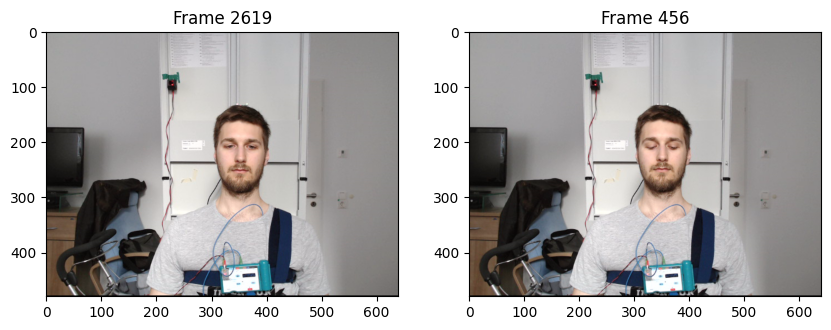

In [60]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

frame1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB)
axes[0].imshow(frame1)
axes[0].set_title(f'Frame {frame_inx1}')

frame2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2RGB)
axes[1].imshow(frame2)
axes[1].set_title(f'Frame {frame_inx2}')

## Frame difference

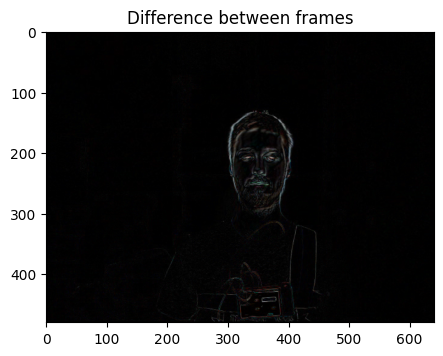

In [61]:
frame_diff = cv2.absdiff(frame1, frame2)

plt.figure(figsize=(5, 5))
plt.imshow(frame_diff)
plt.title('Difference between frames')
plt.show()

## Face detection

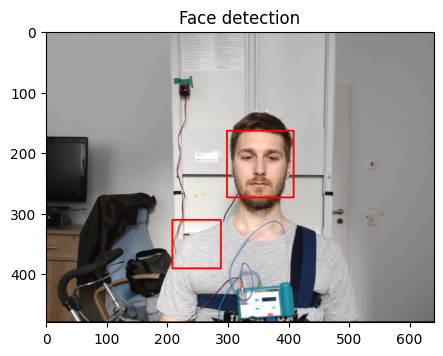

In [62]:
# Detect the face in the first frame with Viola Jones algorithm
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

gray_frame1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
faces = face_cascade.detectMultiScale(gray_frame1, 1.1, 4)

for (x, y, w, h) in faces:
    cv2.rectangle(frame1, (x, y), (x + w, y + h), (255, 0, 0), 2)

plt.figure(figsize=(5, 5))
plt.imshow(frame1)
plt.title('Face detection')
plt.show()